# Project description


Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.

We need to predict whether a customer will leave the bank soon. You have the data on clients’ past behavior and termination of contracts with the bank.
Build a model with the maximum possible F1 score. F1 score should be at least 0.59. Check the F1 for the test set.
Additionally, measure the AUC-ROC metric and compare it with the F1.

## Download and prepare the data

**Import the libraries:**

In [22]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from scipy import stats as st
from joblib import dump
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score

**Import data:**

In [23]:
churn = pd.read_csv('/datasets/Churn.csv')
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Missing values:**

There are missing values in one of the columns. We can fill the data with the median but it can affect the accuracy of the future model. Tenure seems to be an important metric.

We are missing less than 10% of the data. We can drop them.

In [24]:
churn=churn.dropna()
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
RowNumber          9091 non-null int64
CustomerId         9091 non-null int64
Surname            9091 non-null object
CreditScore        9091 non-null int64
Geography          9091 non-null object
Gender             9091 non-null object
Age                9091 non-null int64
Tenure             9091 non-null float64
Balance            9091 non-null float64
NumOfProducts      9091 non-null int64
HasCrCard          9091 non-null int64
IsActiveMember     9091 non-null int64
EstimatedSalary    9091 non-null float64
Exited             9091 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


In [25]:
churn.head(15)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


**Preprocessing column names:**

In [26]:
churn.columns= churn.columns.str.lower()
churn.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

**Preparing data for the model training:**

We have three columns with categorical data.
1. We can drop the surname column, it shpuldn't be used for model training.
2. We can use OHE for gender column.
3. We probably will use tree-based models so we will use Label Encoding for the Geography column.

Columns like "rownumber" and "customerid" can confuse our model. So we will drop them as well.

In [27]:
churn['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [28]:
data=churn.drop(['surname','rownumber','customerid'], axis=1)


In [29]:
data['gender'] = pd.get_dummies(data['gender'], drop_first=True)
data.head(5)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,0,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2.0,125510.82,1,1,1,79084.10,0


In [30]:
encoder = OrdinalEncoder() 
data[["geography"]] = encoder.fit_transform(data[["geography"]])
data.head(5)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,0.0,0,42,2.0,0.00,1,1,1,101348.88,1
1,608,2.0,0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0.0,0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,0.0,0,39,1.0,0.00,2,0,0,93826.63,0
4,850,2.0,0,43,2.0,125510.82,1,1,1,79084.10,0


**Splitting the data into train, validation and test sets in ratio 60/20/20:**

In [31]:
x = data.drop(columns = ['exited']).copy()
y = data['exited']

x_train2, x_test, y_train2, y_test = train_test_split(x,y, train_size=0.8,random_state=12345)

x_train, x_valid, y_train, y_valid = train_test_split(x_train2,y_train2, test_size=0.25,random_state=12345)

print(x_train2.shape), print(y_train2.shape)
print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)

(7272, 10)
(7272,)
(5454, 10)
(5454,)
(1818, 10)
(1818,)
(1819, 10)
(1819,)


(None, None)

## Examine the balance of classes

### Train the model without taking into account the imbalance

In [32]:
best_params = []
best_accuracy = 0
for n_estimators in range(1,100):
    for max_depth in range(2,12):
        model_rf_clf = RandomForestClassifier(random_state=12345,
                                                          n_estimators=n_estimators,
                                                          max_depth=max_depth)
        model_rf_clf.fit(x_train, y_train)
        predictions = model_rf_clf.predict(x_valid)
        accuracy = accuracy_score(y_valid, predictions)
        if accuracy > best_accuracy:
            best_params = [n_estimators, max_depth]
            best_accuracy = accuracy

In [33]:
print('Accuracy:', best_accuracy)
print('Best_parameters:',best_params)

Accuracy: 0.8597359735973598
Best_parameters: [29, 11]


In [34]:
model = RandomForestClassifier(random_state=12345,n_estimators=29,max_depth=11)
model.fit(x_train, y_train)
predicted_valid = model.predict(x_valid)

### Confusion matrix

In [35]:
print(confusion_matrix(y_valid, predicted_valid))

[[1410   42]
 [ 213  153]]


True negative answers: 1410

True positive answers: 153

False negative answers: 213

False positive answers: 42

**The model sees more negative answers than it should.**

### Recall, precision, F1 score

In [36]:
print('Recall:',recall_score(y_valid, predicted_valid))

Recall: 0.4180327868852459


**Model isn't good at identifying true positives.**

In [37]:
print('Precision:',precision_score(y_valid, predicted_valid))

Precision: 0.7846153846153846


**On the other hand, about 80% of the results model gave us can be considered relevant.**

In [38]:
print('F1:',f1_score(y_valid, predicted_valid))

F1: 0.5454545454545455


The goal for F1 score is 0.59.

**The model isn't good enough. It gives too many false negative answers.**

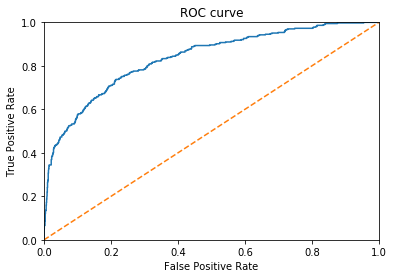

In [39]:
probabilities_valid = model.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid) 
# < write code here >

plt.figure()

# < plot the graph >
plt.plot(fpr, tpr)

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

# < use the functions plt.xlim() and plt.ylim() to
#   set the boundary for the axes from 0 to 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# < use the functions plt.xlabel() and plt.ylabel() to
#   name the axes "False Positive Rate" and "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
# < add the heading "ROC curve" with the function plt.title() >

plt.show()

In [41]:
auc_roc=roc_auc_score(y_valid, probabilities_one_valid)
print(auc_roc)

0.8348321139863614


## Improve the quality of the model

### Class Weight Adjustment

In [32]:
model_1 = RandomForestClassifier(random_state=12345,n_estimators=29,max_depth=11,class_weight='balanced')
model_1.fit(x_train, y_train)
predicted_valid = model_1.predict(x_valid)
print('F1:',f1_score(y_valid, predicted_valid))

F1: 0.5676470588235294


### Upsampling

In [20]:
features_zeros = x_train[y_train == 0]
features_ones = x_train[y_train == 1]
target_zeros = y_train[y_train == 0]
target_ones = y_train[y_train == 1]

print(features_zeros.shape), print(target_zeros.shape)
print(features_ones.shape), print(target_ones.shape)
print(len(target_zeros)/len(target_ones))

(4335, 10)
(4335,)
(1119, 10)
(1119,)
3.8739946380697052


In [19]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    x_train, y_train, 4
)


model_2=RandomForestClassifier(random_state=12345,n_estimators=29,max_depth=11)
#,class_weight='balanced')
model_2.fit(features_upsampled, target_upsampled)
predicted_valid=model_2.predict(x_valid)
print('F1:', f1_score(y_valid, predicted_valid))


F1: 0.5814863102998696


### Combining upsampling and downsampling

In [42]:
def resample(features, target, repeat,fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_resampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones] * repeat)
    target_resampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones] * repeat)

    features_resampled, target_resampled = shuffle(
        features_resampled, target_resampled, random_state=12345
    )

    return features_resampled, target_resampled


In [43]:
best_params = []
best_f1 = 0

for i in range(1,15):
    for k in np.arange(0.1,1,0.1):
        features_resampled, target_resampled = resample(x_train, y_train,i,k)
        model_3=RandomForestClassifier(random_state=12345,n_estimators=29,max_depth=11,class_weight='balanced')
        model_3.fit(features_resampled, target_resampled)
        predicted_valid=model_3.predict(x_valid)
        f1=f1_score(y_valid, predicted_valid)
        #print('F1:', f1_score(y_valid, predicted_valid),i,k)
        
        if f1 > best_f1:
            best_params = [i, k]
            best_f1 = f1

In [44]:
best_params

[2, 0.6]

In [45]:
print('F1:', best_f1)

F1: 0.5990220048899756


In [46]:
features_resampled, target_resampled = resample(x_train, y_train,2,0.6)
model_3=RandomForestClassifier(random_state=12345,n_estimators=29,max_depth=11,class_weight='balanced')
model_3.fit(features_resampled, target_resampled)
predicted_valid=model_3.predict(x_valid)
print('F1:',f1_score(y_valid, predicted_valid))
print('Accuracy:',accuracy_score(y_valid, predicted_valid))

F1: 0.5990220048899756
Accuracy: 0.8195819581958196


**We managed to improve F1 score up to the target.**

### ROC curve

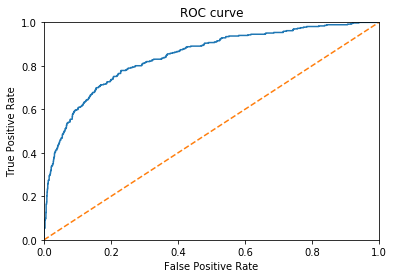

In [47]:
probabilities_valid = model_3.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid) 
# < write code here >

plt.figure()

# < plot the graph >
plt.plot(fpr, tpr)

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

# < use the functions plt.xlim() and plt.ylim() to
#   set the boundary for the axes from 0 to 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# < use the functions plt.xlabel() and plt.ylabel() to
#   name the axes "False Positive Rate" and "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
# < add the heading "ROC curve" with the function plt.title() >

plt.show()

In [48]:
auc_roc=roc_auc_score(y_valid, probabilities_one_valid)
print(auc_roc)

0.844397778078851


## Final testing

In [49]:
features_resampled, target_resampled = resample(x_train2, y_train2,3,0.7000000000000001)
model_3=RandomForestClassifier(random_state=12345,n_estimators=29,max_depth=11,class_weight='balanced')
model_3.fit(features_resampled, target_resampled)
predicted_valid=model_3.predict(x_test)
print('F1:',f1_score(y_test, predicted_valid))
print('Accuracy:',accuracy_score(y_test, predicted_valid))

F1: 0.5945330296127562
Accuracy: 0.8042880703683343


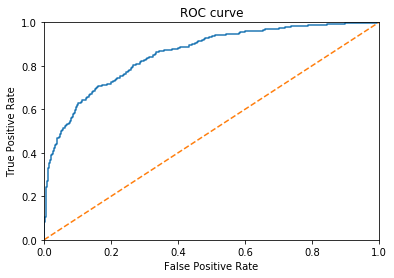

In [50]:
probabilities_valid = model_3.predict_proba(x_test)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid) 
# < write code here >

plt.figure()

# < plot the graph >
plt.plot(fpr, tpr)

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

# < use the functions plt.xlim() and plt.ylim() to
#   set the boundary for the axes from 0 to 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# < use the functions plt.xlabel() and plt.ylabel() to
#   name the axes "False Positive Rate" and "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
# < add the heading "ROC curve" with the function plt.title() >

plt.show()

In [51]:
auc_roc=roc_auc_score(y_test, probabilities_one_valid)
print(auc_roc)

0.8555948042239043


The area under the ROC curve increased, our model got better at prediction the target.